## Generate data
We use valve equation to come up with a dataset that we will later use for regression.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# define a function for valve equation
def valve_flow(dp, op, k):
    
    print('Starting flow calculation for dp='+ str(dp), ', op='+ str(op)+', k='+str(k))
    q = op * k * np.sqrt(dp)
    print('Calculation finished')
    
    return q

# generate arrays of inputs
openings = np.linspace(0, 1, 10)
dps = np.linspace(0, 200, 10)
ks = np.linspace(0, 100000, 10)

# create an empty table, and specify the column name
data = pd.DataFrame(columns=['k', 'op', 'dp', 'q'])

# go through all the possible permutations of the inputs, 
# calculate the outputs and write them in the empty table
for op in openings:
    for dp in dps:
        for k in ks:
            q = valve_flow(dp, op, k)            
            data.loc[len(data)] = [k, op, dp, q]

# write the table into a csv file
data.to_csv('valve_data.csv')

Starting flow calculation for dp=0.0 , op=0.0, k=0.0
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=11111.111111111111
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=22222.222222222223
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=33333.333333333336
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=44444.444444444445
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=55555.555555555555
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=66666.66666666667
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=77777.77777777778
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=88888.88888888889
Calculation finished
Starting flow calculation for dp=0.0 , op=0.0, k=100000.0
Calculation finished
Starting flow calculation for dp=22.22222222222222 , op=0.0, k=0.0
Calculation finished
Starting flow calculation for dp=22.22222222222222

## Import data and visualise 

In [ ]:
# import the data 
my_data = pd.read_csv('valve_data.csv')

In [ ]:
# visualise the data
import plotly.express as px
fig = px.scatter_3d(my_data, x="op", y="dp", z="q", color="k")
fig.show()

## Preprocess data

In [ ]:
# we borrow some preprocessing tools from sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
# define what should be the inputs and outputs
X_raw = my_data [ ['op', 'k', 'dp'] ]
y_raw = my_data['q'] 

In [ ]:
# we use minmax scaler to normalise inputs to be between 0 to 1
X_normalizer = preprocessing.MinMaxScaler().fit(X_raw)
X = X_normalizer.transform(X_raw)

In [ ]:
# we can also normalise data manually
# here, we just divide the output by 1e6 so that all the data is roughly between 0 to 1
y = y_raw / 1e6

In [ ]:
# split and randomise data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Build neural network and train it

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# configure some settings that we will use for model training later
my_optimizer = keras.optimizers.Adam(learning_rate=0.0025)
my_metric = tf.keras.metrics.MeanAbsoluteError()

In [ ]:
# configure and build the neural network
model = Sequential()
model.add(Dense(5, input_dim=3, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mae', optimizer=my_optimizer, metrics=my_metric)

In [ ]:
# train the model, 
# we assign the output to "history" so that we can monitor it's performance history
history = model.fit(X_train, y_train, verbose=1, epochs=1000, validation_split=0.2)

Epoch 1/1000
20/20 [==============================] - 1s 12ms/step - loss: 0.2711 - mean_absolute_error: 0.2711 - val_loss: 0.2652 - val_mean_absolute_error: 0.2652
Epoch 2/1000
20/20 [==============================] - 0s 4ms/step - loss: 0.2473 - mean_absolute_error: 0.2473 - val_loss: 0.2448 - val_mean_absolute_error: 0.2448
Epoch 3/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2292 - mean_absolute_error: 0.2292 - val_loss: 0.2298 - val_mean_absolute_error: 0.2298
Epoch 4/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2173 - mean_absolute_error: 0.2173 - val_loss: 0.2187 - val_mean_absolute_error: 0.2187
Epoch 5/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2088 - mean_absolute_error: 0.2088 - val_loss: 0.2116 - val_mean_absolute_error: 0.2116
Epoch 6/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2032 - mean_absolute_error: 0.2032 - val_loss: 0.2069 - val_mean_absolute_error: 0.2069
Epoch 7/1000
20

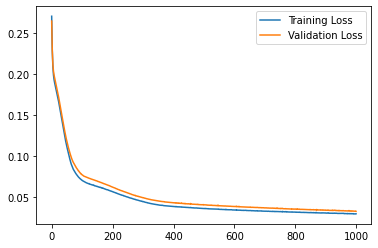

In [ ]:
#%% plot loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

## Check neural network performance

In [ ]:
# use the trained model to predict y given X for train and test dataset
predicted_y_train = model.predict(X_train)
predicted_y_test = model.predict(X_test)

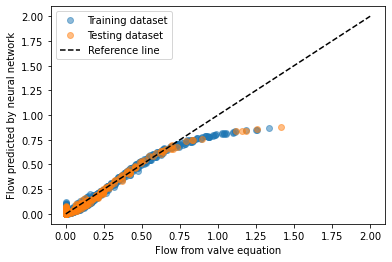

In [ ]:
plt.figure()
plt.plot(y_train, predicted_y_train,'o', alpha=0.5, label='Training dataset')
plt.plot(y_test, predicted_y_test,'o', alpha=0.5, label='Testing dataset')
plt.plot([0,2],[0,2],'--k', label='Reference line') # 45 degree reference line
plt.xlabel('Flow from valve equation')
plt.ylabel('Flow predicted by neural network')
plt.legend()